In [ ]:
#KEY delete
%load_ext autoreload
%autoreload 2

In [ ]:
from notebook import *
# if you get something about NUMEXPR_MAX_THREADS being set incorrectly, don't worry.  It's not a problem.

#KEY include Namebox.ipynb

<div style=" font-size: 300% !important;
    margin-top: 1.5em;
    margin-bottom: 1.5em;
    font-weight: bold;
    line-height: 1.0;
    text-align:center;">Lab 3 Demos</div>

<div class="_solution">
    
Method 2: 

Use the measurement tool (the ruler icon) and select the whole area:
    
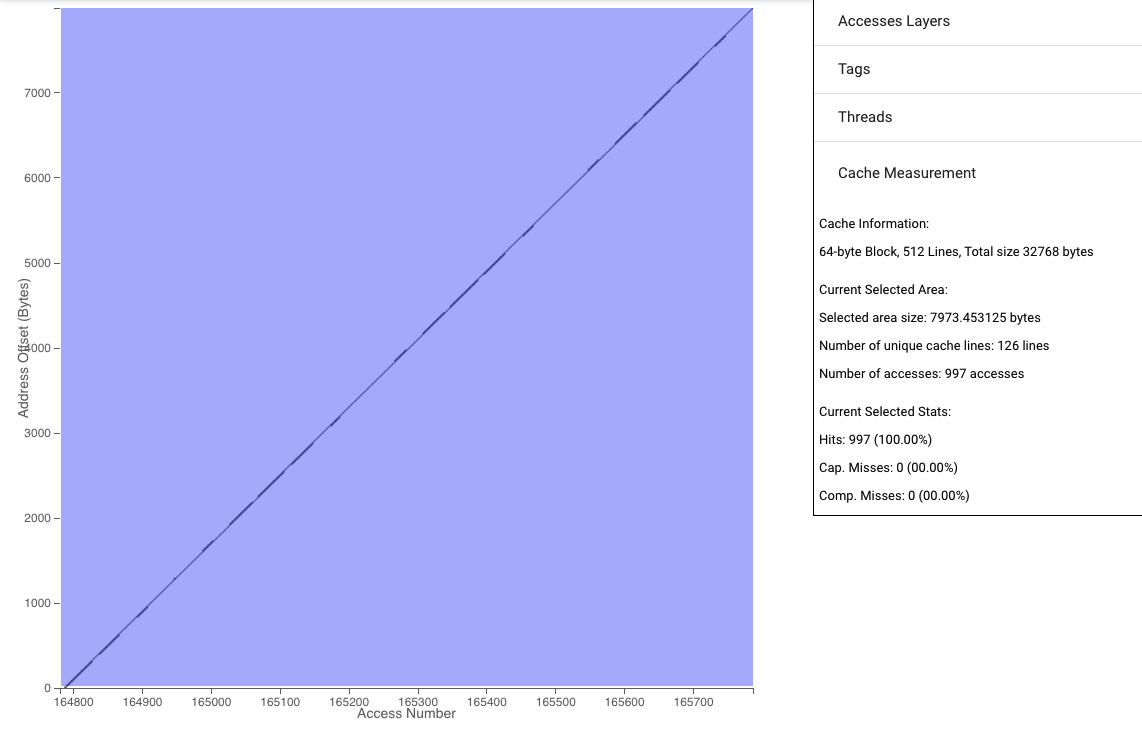
    
On the right under "Cache Measurement" it has "selected area size" and "number of accesses".
</div>

# Struct Layout

In [ ]:
t = fiddle("struct_offset.cpp", function="offset", run=["local"],
code=r"""
#include<cstdint>
#include<iostream>
#include"function_map.hpp"

//__attribute__((packed)) 

struct foo {
    int a;
    int b;
    char c;
    uint64_t d;
};  
#define GET_OFFSET(T, F) (reinterpret_cast<size_t>(&(*reinterpret_cast<T*>(NULL)).F))

extern "C"
uint64_t* offset(uint64_t * data, uint64_t size, uint64_t arg1) {

    std::cout << "\n";
    std::cout << "foo.a " << GET_OFFSET(foo, a) << "\n";
    std::cout << "foo.b " << GET_OFFSET(foo, b) << "\n";
    std::cout << "foo.c " << GET_OFFSET(foo, c) << "\n";
    std::cout << "foo.d " << GET_OFFSET(foo, d) << "\n";
    return NULL;
}

FUNCTION(one_array_1arg, offset);
""")


# Memory Latency

In [ ]:
t = fiddle("miss_machine.cpp", function="miss_machine", opt="-O3 ",
code=r"""
#include<cstdint>
#include<vector>
#include<algorithm>
#include"function_map.hpp"
  
struct MissingLink {
    struct MissingLink* next;  
    uint64_t junk[7]; 
};

extern "C"
struct MissingLink * miss(struct MissingLink * start, uint64_t count) {
    for(uint64_t i = 0; i < count; i++) {
        start = start->next;
    }
    return start;
}

extern "C"
uint64_t* miss_machine(uint64_t * data, uint64_t size, uint64_t arg1) {

    auto array = new struct MissingLink[size];
 
    std::vector<uint64_t> index;
    for(uint64_t i = 0; i < size; i++) {
        index.push_back(i);
    }
    // Randomize the list of indexes.
    std::random_shuffle(index.begin(), index.end());

    // Convert the indexes into pointers.
    for(uint64_t i = 0; i < size; i++) {
        array[index[i]].next = &array[index[(i + 1) % size]]; 
    } 

    MissingLink * start = &array[0];
    start = miss(start, arg1); 
    return reinterpret_cast<uint64_t*>(start); 
} 

FUNCTION(one_array_1arg, miss_machine);
""")
render_code("miss_machine.cpp")

In [ ]:
f = fiddle("miss_machine.cpp", function="miss", opt="-O3")
display(f.cfg)

* `size`:  How many `MissingLink`s are in the machine.
* `arg1`:  How many links to traverse.

## How Big should `size` be to exactly fill my 32kB L1 Cache?

## How Big to fill my L2 cache?

## How Big to "blow out" all my caches?

In [ ]:

!cse142 job run --force lscpu

In [ ]:
t = fiddle("miss_machine.cpp", function="miss_machine", name="L1", opt="-O3", cmdline=f"--size 512 4096 196608 1966080 --arg1 100000000 ", perf_cmdline="--stat-set L1.cfg --MHz 3500", run=["perf_count"])
t = fiddle("miss_machine.cpp", function="miss_machine", name="L2", opt="-O3", cmdline=f"--size 512 4096 196608 1966080 --arg1 100000000 ", perf_cmdline="--stat-set L2.cfg --MHz 3500", run=["perf_count"])
t = fiddle("miss_machine.cpp", function="miss_machine", name="L3", opt="-O3", cmdline=f"--size 512 4096 196608 1966080 --arg1 100000000 ", perf_cmdline="--stat-set L3.cfg --MHz 3500", run=["perf_count"])



In [ ]:
L1 = render_csv("L1.csv")
L2 = render_csv("L2.csv")
L3 = render_csv("L3.csv")

L1['L2_MPI'] = L2["L2_MPI"]
L1['L3_MPI'] = L3["L3_MPI"]
L1["cycles/link"] = L1["cycles"]/L1["arg1"]
display(L1[["size", "arg1","IC", "CPI", "CT", "ET", "L1_MPI", "L2_MPI", "L3_MPI", "cycles/link"]])


# Unmiss Machine

In [ ]:
t = fiddle("unmiss_machine.cpp", function="unmiss_machine", opt="-Og",
code=r"""
#include<cstdint>
#include<vector>
#include<algorithm>
#include"function_map.hpp"
  
struct MissingLink {
    struct MissingLink* next;  
    uint64_t junk[7]; 
};

extern "C"
struct MissingLink * unmiss(struct MissingLink * start, uint64_t count) {
    for(uint64_t i = 0; i < count; i++) {
            //start += 1;
    }
    return start;
}

extern "C"
uint64_t* unmiss_machine(uint64_t * data, uint64_t size, uint64_t arg1) {

    MissingLink * start = NULL;
    start = unmiss(start, arg1); 
    return reinterpret_cast<uint64_t*>(start); 
} 

FUNCTION(one_array_1arg, unmiss_machine);   
""")
render_code("unmiss_machine.cpp")

In [ ]:
f = fiddle("unmiss_machine.cpp", function="unmiss", opt="-Og")
display(f.cfg)
t = fiddle("unmiss_machine.cpp", function="unmiss_machine", name="un", opt="-Og", cmdline=f"--size 196608 --arg1 100000000 ", perf_cmdline="--stat-set L1.cfg --MHz 3500", run=["perf_count"])


In [ ]:
un=render_csv("un.csv")
un["cycles/link"] = un["cycles"]/un["arg1"]
display(un[["size", "arg1","IC", "CPI", "CT", "ET", "cycles/link"]])

# Alignment

In [ ]:
t = fiddle("ua_miss_machine.cpp", function="ua_miss_machine", opt="-O3 ",
code=r"""
#include<cstdint>
#include<vector>
#include<algorithm>
#include"function_map.hpp"
  
struct MissingLink {
    struct MissingLink* next;  
    uint64_t junk[7]; 
};

extern "C"
struct MissingLink * miss(struct MissingLink * start, uint64_t count) {
    for(uint64_t i = 0; i < count; i++) {
        start = start->next;
    }
    return start;
}

extern "C"
uint64_t* ua_miss_machine(uint64_t * data, uint64_t size, uint64_t arg1) {

    auto array = new struct MissingLink[size + 1];
    array = reinterpret_cast<struct MissingLink *>(reinterpret_cast<uintptr_t>(array)+1);
    
    std::vector<uint64_t> index;
    for(uint64_t i = 0; i < size; i++) {
        index.push_back(i);
    }
    // Randomize the list of indexes.
    std::random_shuffle(index.begin(), index.end());

    // Convert the indexes into pointers.
    for(uint64_t i = 0; i < size; i++) {
        array[index[i]].next = &array[index[(i + 1) % size]]; 
    } 

    MissingLink * start = &array[0];
    start = miss(start, arg1); 
    return reinterpret_cast<uint64_t*>(start); 
} 

FUNCTION(one_array_1arg, ua_miss_machine);
""")
#render_code("ua_miss_machine.cpp")

In [ ]:
t = fiddle("ua_miss_machine.cpp", function="ua_miss_machine", name="L1_ua", opt="-O3", cmdline=f"--size 512 4096 196608 1966080 --arg1 100000000 ", perf_cmdline="--stat-set L1.cfg --MHz 3500", run=["perf_count"])
#t = fiddle("miss_machine.cpp", function="miss_machine", name="L2", opt="-O3", cmdline=f"--size 512 4096 196608 1966080 --arg1 100000000 ", perf_cmdline="--stat-set L2.cfg --MHz 3500", run=["perf_count"])
#t = fiddle("miss_machine.cpp", function="miss_machine", name="L3", opt="-O3", cmdline=f"--size 512 4096 196608 1966080 --arg1 100000000 ", perf_cmdline="--stat-set L3.cfg --MHz 3500", run=["perf_count"])

In [ ]:
ua=render_csv("L1_ua.csv")
ua["cycles/link"] = ua["cycles"]/ua["arg1"]
display(ua[["size", "arg1","IC", "CPI", "CT", "ET", "cycles/link"]])


<div class="_solution">

Sound familiar?
    
</div>

# Moneta Demo

In [ ]:
#KEY answer_cell
!mtrace --trace gcc --memops 10000000 --skip 10000000 -- /usr/lib/gcc/x86_64-linux-gnu/8/cc1plus -quiet -v -I /cse142L/cse141pp-archlab/libarchlab -I /cse142L/cse141pp-archlab -I /usr/local/include -I /cse142L/CSE141pp-SimpleCNN/googletest/googletest/include -I /cse142L/CSE141pp-SimpleCNN -I build/ -I /cse142L/CSE141pp-Tool-Moneta/moneta/ -I . -imultiarch x86_64-linux-gnu -MMD build/fiddle.d -MQ build/fiddle.s -D_GNU_SOURCE -D_REENTRANT fiddle.cpp -quiet -dumpbase fiddle.cpp -mtune=generic -march=x86-64 -auxbase-strip build/fiddle.s -g -g0 -O3 -Wall -Werror -std=gnu++11 -version -p -fPIC -o build/fiddle.s -fstack-protector-strong -Wformat-security
show_trace("./gcc_0.hdf5")